# Introducción a redes neuronales y backpropagaton - Parte 2

Basada en la primera lección del curso [Neural Networks: Zero to Hero](https://github.com/karpathy/nn-zero-to-hero/tree/master) de Andrej Karpathy y su proyecto [Micrograd](https://github.com/karpathy/micrograd).

## Utils

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


---
## Una neurona

Ahora que tenemos un framework para calcular **backpropagation** de cualquier expresión matemática (que utilize sumas y multiplicaciones) podemos crear nuestra primera neurona.

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fcs231n.github.io%2Fassets%2Fnn1%2Fneuron_model.jpeg&f=1&nofb=1&ipt=5e2ecb550d2aa63379f5d2563de7e1571a410841d95fd4ed2ad4a45244f05204" width="500">

Una **neurona** no es más que una expresión matemática:  

- Tenemos $x_n$, nuestros **inputs**.  
- Cada input se multiplica por un **peso** $w_n$.  
- Luego, se suman todos los productos y se agrega un **bias** $b$.  

Todo esto podemos implementarlo utilizando nuestro pequeño motor de backpropagation.

### Función de activación

Lo único que nos falta para tener una neurona completa es tener alguna clase de función de activación. Existen muchas opciones, para este ejemplo vamos a implementar la función tangente hiperbolica como función de activacion:
$$
tanh\ x = \frac{sinh\ x}{cosh\ x} = \frac{e^{2x} + 1}{e^{2x} - 1}
$$

Y necestiamos también su derivada, que se calcula como:

$$
\frac{d}{dx} tanh\ x = 1 - tanh^2\ x
$$


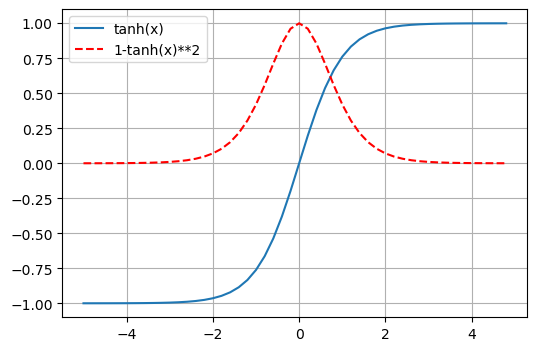

In [4]:
x = np.arange(-5, 5, 0.2)

plt.figure(figsize=(6, 4))
plt.plot(x, np.tanh(x), label="tanh(x)")
plt.plot(x, 1-np.tanh(x)**2, 'r--', label="1-tanh(x)**2")

plt.grid()
plt.legend()
plt.show()

In [5]:
# Nueva implementación de la clase Value
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data},label={self.label})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  # Implementamos la función tanh con su backward
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) # Definimos tanh
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad # Como siempre, multiplicamos por out.grad para seguir la regla de la cadena
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

---
### Implementamos una neurona

In [8]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b') # El bias elegido es para que los gradientes den números lindos :)

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# Función de actvación
o = n.tanh(); o.label = 'o'

draw_dot(o)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [ ]:
o.backward()
draw_dot(o)

## Comprobando con Pytorch

Vamos a construir esta misma neurona utilizando Pytorch, para comprobar que los resultados son los mismos.

Algunas diferencias con Pytorch respecto a nuestra implementación son:
- Pytorch trabaja con tensores de cualquier shape, nuestro motor solo con escalares.
- Pytorch requiere explicitar que valores requieren calcular el gradiente, esto es útil para evitar calcular aquellos gradientes que no son necesarios y ser más eficiente.
- Pytorch por defecto utiliza float32, mientras que Python utiliza float64, entonces para que la precision de los valores coincida, necesitamos decirle a Pytorch que utilize `double()` para usar float64.

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('\n---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

---
## Algunas mejoras finales para nuestra clase Value

En esta versión hemos agregado soporte y mejoras en las operaciones:

### 1. Soporte para operaciones con floats/ints

Si intentaramos sumar un `Value` con un `int` o `float` tendriamos un error, porque no existe una función que permita esa operación, asi que vamos a implementarlo.

### 2. Nuevas operaciones adicionales

Se agregaron varios métodos para cubrir casos comúnes.

- **`__rmul__`**: permite que la multiplicación funcione si el número está a la izquierda (por ejemplo, `2 * x`).  
- **`__radd__`**: permite que la suma funcione si el número está a la izquierda (por ejemplo, `2 + x`).  
- **`__neg__`**: define la operación de negación `-x`.  
- **`__sub__`**: permite restar usando la suma y la negación, es decir, `x - y` se interpreta como `x + (-y)`.

Estas operaciones hacen que podamos escribir expresiones matemáticas de manera más **natural y legible**, sin preocuparnos por el orden de los operandos o la conversión manual de números a `Value`.

### 3. Operación de potencia

- **`__pow__`**: habilita la operación de potencia con exponentes numéricos (`int` o `float`).  
Internamente, también define cómo se propaga el gradiente usando la regla de la derivada para potencias:  
  
$$
\frac{d}{dx}(x^n) = n \cdot x^{n-1}
$$  

Esto significa que expresiones como `x**2`, `x**3` o incluso raíces como `x**0.5` pueden utilizarse directamente y se integran sin problemas al proceso de *backpropagation*.  

⚠️ **Limitación:** esta implementación solo soporta exponentes numéricos. No es posible calcular `x ** y` si tanto la base como el exponente son instancias de `Value`, ya que el cálculo y la derivada en ese caso son más complejos.


In [ ]:
# Nueva implementación de la clase Value
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other) # Agregamos soporte para sumar Value y float/int
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other) # Agregamos soporte para multiplicar Value y float/int
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

---
## Construyendo una libreria de redes neuronales

### Neurona

In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1), label='w') for _ in range(nin)]
    self.b = Value(random.uniform(-1,1), label='b')

  def __call__(self, x): # Forward
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

In [ ]:
x = [2.0, 3.0]
n = Neuron(2)
out = n(x)
out

In [ ]:
draw_dot(out)

### Capa densa

Podemos definir una capa densa como una lista de neuronas, cada neurona tendra un `nin` que define el tamaño de entrada.

`nout` no es más que la cantidad de neuronas que va a tener nuestra capa densa, que además define el tamaño de la salida de la capa.

In [ ]:
class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

In [ ]:
x = [2.0, 3.0]
n = Layer(2,3)
out = n(x)
out

### Multi-Layer Perceptron

Podemos entonces definirnos una arquitectura básica de `MLP`, una red neuronal con capas densas fully-connected.

Podemos crearnos nuestro `MLP` como una lista de `Capas densas`, donde tenemos un input de la red, que también será el input de la primer capa, y luego una lista de outputs, cada una nos va a decir el tamaño del output de la capa densa, que como vimos define la cantidad de neuronas de la capa.

In [ ]:
class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fcs231n.github.io%2Fassets%2Fnn1%2Fneural_net2.jpeg&f=1&nofb=1&ipt=28a64b3c8e5d972ff118636e9e299aa4219291932c782694938ffad62c4c6dc3" width="500">



In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

In [ ]:
draw_dot(n(x))

## Dataset y funcion de Loss

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
ypred = [n(x) for x in xs]
ypred

In [ ]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)] # Squared Difference

In [ ]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

In [ ]:
loss.backward()

In [ ]:
print("Data: ",n.layers[0].neurons[0].w[0].data)
print("Grad: ",n.layers[0].neurons[0].w[0].grad)

## Entrenamiento de la red

In [ ]:
len(n.parameters())

In [ ]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [ ]:
n.layers[0].neurons[0].w[0].data

In [ ]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

---

### Loop de entrenamiento

Finalmente, podemos construir un **loop de entrenamiento**, que se parece mucho al típico loop usado en redes neuronales con PyTorch.

#### zero_grad()

Hay un paso adicional que es fundamental durante el entrenamiento: **reiniciar los gradientes**.  

Cuando llamamos a `backward()` y ajustamos los pesos según los gradientes calculados, los valores de los gradientes se **acumulan** en los nodos `Value`.  
Si no los reiniciamos antes de la siguiente iteración, los gradientes viejos se sumarían a los nuevos y **darían resultados incorrectos**.

Por eso, antes de volver a calcular `backward()`, debemos recorrer todos los parámetros y poner su gradiente a 0.  

Este paso también existe en PyTorch, y se realiza mediante la función `zero_grad()`.



<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fd5ln38p3754yc.cloudfront.net%2Fconference_icons%2F301807%2Flarge%2F301807-1546762188.png%3F1546762188&f=1&nofb=1&ipt=580aba045a82240701a8966abacfcaf322863327d9a9e82fb8a812c958d2ef57" width="500">


In [ ]:
epochs = 100
learning_rate = 0.01

for k in range(epochs):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters(): # zero_grad()
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -learning_rate * p.grad

  print(k, loss.data)


In [ ]:
ypred = [n(x) for x in xs]
ypred